In [1]:
import sys
from pathlib import Path

def in_colab():
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

if in_colab():
    from google.colab import drive
    drive.mount("/content/drive")
    REPO_PATH = Path("/content/drive/My Drive/einstein_program_synthesis/scripts")  # ← adjust if needed
else:
    REPO_PATH = Path.home() / "Documents" / "Code" / "einstein_program_synthesis" / "scripts"  # ← adjust

sys.path.insert(0, str(REPO_PATH.resolve()))
print("Using repo path:", REPO_PATH.resolve())
print("Exists?", REPO_PATH.exists())
print("Contains:", [p.name for p in REPO_PATH.glob("*.py")])


Using repo path: /home/omar/Documents/Code/einstein_program_synthesis/scripts
Exists? True
Contains: ['synthesis_primitives.py', 'einstein_types.py', 'context.py', 'judgments.py', 'typing_rules.py', 'simplify.py', 'bayes_neural_search.py', 'pure_bayes_search.py', 'synthesis_state.py', 'enumeration_search.py']


# Enumeration search

In [2]:
import importlib
import enumeration_search as es
from einstein_types import Art, Emp

es = importlib.reload(es)
print("module path:", es.__file__)


module path: /home/omar/Documents/Code/einstein_program_synthesis/scripts/enumeration_search.py


## Search settings

In [3]:
es.MAX_SAMPLES  = 200 # 1000
es.CHAIN_LENGTH = 8
es.USE_GREEDY   = False   # True = greedy; False = weighted

es.TERM_WEIGHT  = 0.7
es.TYPE_WEIGHT  = 0.3

es.GOAL_TERM    = "t - u*x/c**2"
es.GOAL_TYPE    = Art & Emp
es.TARGET_TERM  = "f(-k*y + t*w - k*u*x/c)"

es.BACKWARD_NAMES = {"BWD"}

es.ENABLE_NO_REPEAT             = True # False
es.ENABLE_SUB1_CONSTRAINT       = True # False
es.ENABLE_SIM_SIMPUS_CONSTRAINT = True # False
es.ENABLE_SIMPUS_SIM_CONSTRAINT = True # False
es.ENABLE_BACKWARD_GATE         = True # False
es.ENABLE_BACKWARD_ONLY_MODE    = False

es.VERBOSE = True

N_RUNS = 150

## Search

In [4]:
import cProfile, pstats, io, time

t0 = time.perf_counter()
pr = cProfile.Profile(); pr.enable()

results = es.run_experiments(
    N_RUNS,
    max_samples=es.MAX_SAMPLES,
    parallel=False
)

pr.disable()
s = io.StringIO()
pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime").print_stats(20)
print("\n=== PROFILING RESULTS ===")
print(s.getvalue())

t1 = time.perf_counter()
print(f"\n✅ Total elapsed time: {t1 - t0:.2f} seconds")


Run   1: ❌ not reached
Run   2: ✅ reached at chain 129
Run   3: ❌ not reached
Run   4: ❌ not reached
Run   5: ✅ reached at chain 51
Run   6: ✅ reached at chain 58
Run   7: ✅ reached at chain 125
Run   8: ❌ not reached
Run   9: ❌ not reached
Run  10: ❌ not reached
Run  11: ✅ reached at chain 121
Run  12: ❌ not reached
Run  13: ✅ reached at chain 176
Run  14: ❌ not reached
Run  15: ✅ reached at chain 185
Run  16: ✅ reached at chain 129
Run  17: ✅ reached at chain 52
Run  18: ✅ reached at chain 179
Run  19: ✅ reached at chain 193
Run  20: ✅ reached at chain 88
Run  21: ❌ not reached
Run  22: ✅ reached at chain 100
Run  23: ✅ reached at chain 69
Run  24: ✅ reached at chain 180
Run  25: ✅ reached at chain 76
Run  26: ✅ reached at chain 72
Run  27: ❌ not reached
Run  28: ✅ reached at chain 90
Run  29: ❌ not reached
Run  30: ❌ not reached
Run  31: ✅ reached at chain 69
Run  32: ✅ reached at chain 87
Run  33: ❌ not reached
Run  34: ❌ not reached
Run  35: ❌ not reached
Run  36: ✅ reached at cha

## Success indices at which goal is met

In [5]:
success_indices_enum = [r for r in results if r is not None]
print("All program-indices at which the goal was met:")
print(success_indices_enum)


All program-indices at which the goal was met:
[129, 51, 58, 125, 121, 176, 185, 129, 52, 179, 193, 88, 100, 69, 180, 76, 72, 90, 69, 87, 125, 172, 186, 113, 59, 183, 130, 124, 131, 76, 30, 125, 110, 55, 192, 154, 96, 182, 56, 104, 131, 64, 138, 177, 12, 70, 62, 74, 109, 200, 182, 110, 152, 144, 47, 70, 119, 156, 78, 41, 171, 186, 102, 110, 179, 100, 25, 113, 135, 200, 50, 147, 72, 133, 197, 199]


## Save success indices

In [7]:
# Save success indices — works in Colab + VS Code/local
import os
from pathlib import Path
import numpy as np

def get_output_dir() -> Path:
    # 1) explicit override via env var
    env = os.getenv("EPS_OUTPUT_DIR")
    if env:
        return Path(env).expanduser().resolve()

    # 2) Colab (Drive mounted)
    try:
        import google.colab  # type: ignore
        base = Path("/content/drive/MyDrive")
        if not base.exists():
            base = Path("/content/drive/My Drive")  # older mount name
        return base / "einstein_program_synthesis" / "output"
    except Exception:
        pass

    # 3) Local/VS Code: put outputs in repo_root/output (or CWD/output)
    cwd = Path.cwd()
    for p in [cwd, *cwd.parents]:
        if (p / ".git").exists() or (p / "pyproject.toml").exists() or (p / "setup.cfg").exists():
            return p / "output"
    return cwd / "output"

output_dir = get_output_dir()
output_dir.mkdir(parents=True, exist_ok=True)

out_path = output_dir / "success_indices_enum.csv"
np.savetxt(
    out_path,
    success_indices_enum,
    fmt="%d",
    header="success_index",
    delimiter=",",
    comments=""
)

print(f"\n✅ Saved {len(success_indices_enum)} indices to:\n{out_path}")



✅ Saved 76 indices to:
/home/omar/Documents/Code/einstein_program_synthesis/output/success_indices_enum.csv


## Calculate statistics

In [8]:
import numpy as np

def summarize(results):
    # keep numeric, non-None, non-NaN entries
    arr = np.array([x for x in results if x is not None and not (isinstance(x, float) and np.isnan(x))], dtype=float)
    n = arr.size
    if n == 0:
        return {
            "n": 0,
            "mean": None, "std": None, "cv": None,
            "median": None, "iqr": None,
            "q25": None, "q75": None,
            "p50": None, "p90": None, "p95": None,
            "min": None, "max": None,
        }

    mean = float(arr.mean())
    std  = float(arr.std(ddof=1)) if n > 1 else 0.0  # sample std if possible
    q25  = float(np.quantile(arr, 0.25))
    med  = float(np.quantile(arr, 0.50))
    q75  = float(np.quantile(arr, 0.75))
    iqr  = float(q75 - q25)

    stats = {
        "n": n,
        "mean": mean,
        "std": std,
        "cv": (float(std/mean) if mean != 0 else None),
        "median": med,
        "iqr": iqr,
        "q25": q25,
        "q75": q75,
        "p50": med,
        "p90": float(np.percentile(arr, 90)),
        "p95": float(np.percentile(arr, 95)),
        "min": float(arr.min()),
        "max": float(arr.max()),
    }
    return stats

stats = summarize(results)
print(stats)


{'n': 76, 'mean': 116.9342105263158, 'std': 50.7005155861531, 'cv': 0.4335815443397812, 'median': 116.0, 'iqr': 87.75, 'q25': 72.0, 'q75': 159.75, 'p50': 116.0, 'p90': 185.5, 'p95': 194.0, 'min': 12.0, 'max': 200.0}


## Save statistics

In [ ]:
# Save Bayes-Neural statistics — Colab + VS Code/local
import os, csv
from pathlib import Path

def get_output_dir() -> Path:
    # 1) explicit override via env var
    env = os.getenv("EPS_OUTPUT_DIR")
    if env:
        return Path(env).expanduser().resolve()

    # 2) Colab (Drive mounted)
    try:
        import google.colab  # type: ignore
        base = Path("/content/drive/MyDrive")
        if not base.exists():
            base = Path("/content/drive/My Drive")  # older mount name
        return base / "einstein_program_synthesis" / "output"
    except Exception:
        pass

    # 3) Local/VS Code: repo root's output/ (fallback to CWD/output)
    cwd = Path.cwd()
    for p in [cwd, *cwd.parents]:
        if (p / ".git").exists() or (p / "pyproject.toml").exists() or (p / "setup.cfg").exists():
            return p / "output"
    return cwd / "output"

output_dir = get_output_dir()
output_dir.mkdir(parents=True, exist_ok=True)

csv_path = output_dir / "enum_stats.csv"

# stable ordering for columns
cols = ["n","mean","std","cv","median","iqr","q25","q75","p50","p90","p95","min","max"]

with open(csv_path, "w", newline="", encoding="utf-8") as fp:
    writer = csv.writer(fp)
    writer.writerow(cols)
    writer.writerow([stats.get(c, "") for c in cols])  # uses empty if missing

print(f"\n✅ Saved Bayes-Neural stats to:\n{csv_path}")



✅ Saved Bayes-Neural stats to:
/home/omar/Documents/Code/einstein_program_synthesis/output/bayes_neural_stats.csv


## Plot success rate versus program index

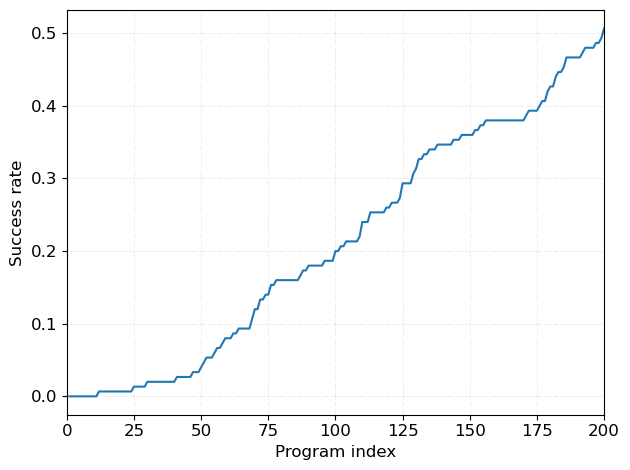

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given success indices from this batch

success_array = np.array(success_indices_enum, dtype=int)
max_program = es.MAX_SAMPLES  # x-axis limit (your sampling budget)

# X axis: program indices 1..max_program
x = np.arange(1, max_program + 1)

# Cumulative success rate at each program index k
success_rate = np.array([(success_array <= k).sum() for k in x]) / max(N_RUNS, 1)

# Plot
plt.figure()
plt.plot(x, success_rate)
plt.xlabel("Program index", fontsize=12)
plt.ylabel("Success rate", fontsize=12)
# plt.title("Success Rate over Program Index")

# Bigger tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Force x-axis from 0 to max_program
plt.xlim(0, max_program)

# Grid a bit darker/heavier (like your screenshot)
plt.grid(
    True,
    color="#CCCCCC",   # darker gray
    linewidth=0.6,     # slightly thicker
    linestyle='-.',    # dashed-dot
    alpha=0.4          # more opaque
)

# Optional: remove top & right spines
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## Reset caches

In [12]:
es.expr_to_str.cache_clear()